In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from pprint import pprint as pprint
from copy import copy as copy


import os
import sys

import re

N_SAMPLES = 70
COLUMNS = ["Date", "Hour", "Code", "Value"]

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [2]:
index_vals = []
files_name = [None] * N_SAMPLES
for ii in os.listdir():
    if "data" in ii:
        index_vals += [int(ii[-2:])]
        files_name[index_vals[-1] - 1] = ii

index_vals.sort()

In [3]:
files_dict = {}
for x,y in zip(index_vals, files_name):
    files_dict[x]=y

In [4]:
dataframe_container = []
preproc_size_container = []
for ii in range(N_SAMPLES):
    temp = pd.read_csv(files_name[ii], sep="\t", encoding="utf-8")
    temp.columns = COLUMNS
    
    preproc_size_container.append(temp.shape[0])
    dataframe_container += [temp]

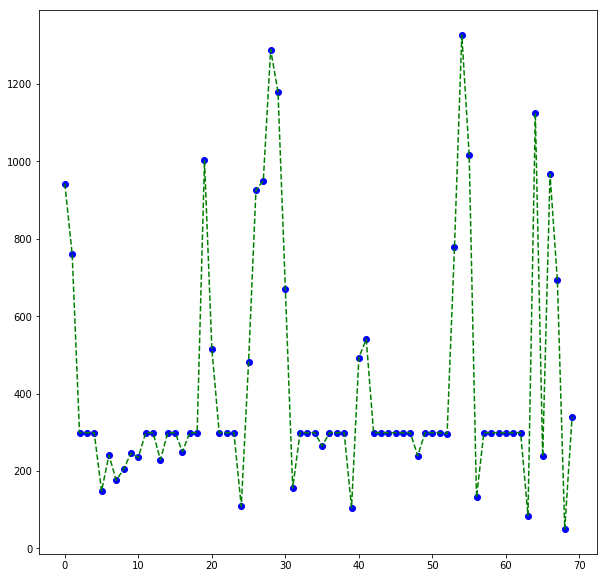

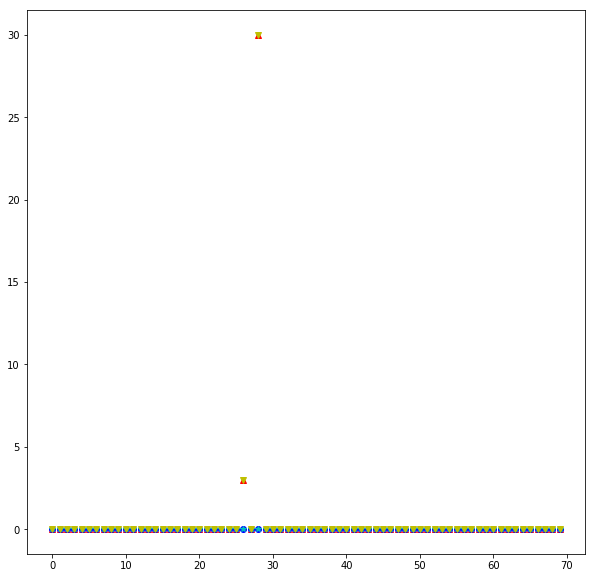

In [5]:
x_temp = np.arange(N_SAMPLES)
y_temp = []
y_na_date_temp = []
y_na_hour_temp = []
y_na_code_temp = []
y_na_value_temp = []
for dfc_element in dataframe_container:
    y_temp.append(dfc_element.shape[0])
    y_na_date_temp.append(dfc_element.Date.isnull().astype(int).sum())
    y_na_hour_temp.append(dfc_element.Hour.isnull().astype(int).sum())
    y_na_code_temp.append(dfc_element.Code.isnull().astype(int).sum())
    y_na_value_temp.append(dfc_element.Value.isnull().astype(int).sum())

na_df = pd.DataFrame(data=np.matrix([y_na_date_temp , y_na_hour_temp , y_na_code_temp , y_na_value_temp]).T, 
                     columns=["na_date", "na_hour", "na_code", "na_value"])

plt.figure(figsize=(10,10))

plt.plot(x_temp, y_temp, "ob")
plt.plot(x_temp, y_temp, "--g")

plt.show()

plt.figure(figsize=(10,10))

plt.plot(na_df.na_date, "^r")
plt.plot(na_df.na_hour, "ob")
plt.plot(na_df.na_code, "*c")
plt.plot(na_df.na_value, "vy")

plt.show()

In [6]:
meta_data_df = pd.DataFrame()
meta_data_df["idx_file"] = x_temp
meta_data_df["n_of_data"] = y_temp

In [7]:
meta_data_df.describe()

,idx_file,n_of_data
count,70.000000,70.000
mean,34.500000,418.000
std,20.351085,304.419
min,0.000000,50.000
25%,17.250000,296.750
50%,34.500000,299.000
75%,51.750000,446.500
max,69.000000,1326.000


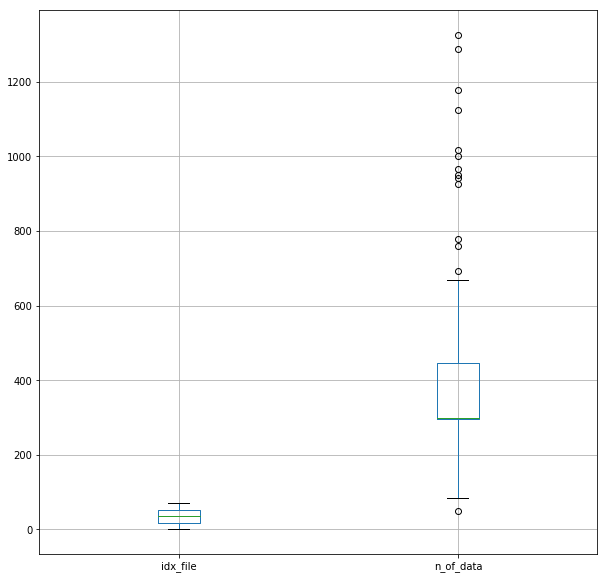

In [8]:
plt.figure(figsize=(10,10))
meta_data_df.boxplot()
plt.show()

In [9]:
code_names = pd.read_csv("./code_names.csv", sep=";", header=0)

code_families = {0:"blood glucose", 1:"insulin dose", 2:"meal ingestion", 3:"exercise activity"}

familie_sublist = [[] for i in range(len(code_families))]
for (ii , ii_str ) in code_families.items():
    for row in code_names.values:
        if ii_str in row[-1]:
            familie_sublist[ii].append(row.tolist())

In [10]:
familie_sublist

[[[48, 'Unspecified blood glucose measurement'],
  [57, 'Unspecified blood glucose measurement'],
  [58, 'Pre-breakfast blood glucose measurement'],
  [59, 'Post-breakfast blood glucose measurement'],
  [60, 'Pre-lunch blood glucose measurement'],
  [61, 'Post-lunch blood glucose measurement'],
  [62, 'Pre-supper blood glucose measurement'],
  [63, 'Post-supper blood glucose measurement'],
  [64, 'Pre-snack blood glucose measurement']],
 [[33, 'Regular insulin dose'],
  [34, 'NPH insulin dose'],
  [35, 'UltraLente insulin dose']],
 [[66, 'Typical meal ingestion'],
  [67, 'More-than-usual meal ingestion'],
  [68, 'Less-than-usual meal ingestion']],
 [[69, 'Typical exercise activity'],
  [70, 'More-than-usual exercise activity'],
  [71, 'Less-than-usual exercise activity']]]

In [11]:
familie_sublist[0]

[[48, 'Unspecified blood glucose measurement'],
 [57, 'Unspecified blood glucose measurement'],
 [58, 'Pre-breakfast blood glucose measurement'],
 [59, 'Post-breakfast blood glucose measurement'],
 [60, 'Pre-lunch blood glucose measurement'],
 [61, 'Post-lunch blood glucose measurement'],
 [62, 'Pre-supper blood glucose measurement'],
 [63, 'Post-supper blood glucose measurement'],
 [64, 'Pre-snack blood glucose measurement']]

In [12]:
def alter_val_int(x_data):
    re_pattern = re.compile(r"\D")
    default_val=-1
    
    if re_pattern.search(x_data):
        output = default_val
    else:
        output = x_data
    
    return output

In [13]:
patched_data = []
for ii in code_names.T:
    
    [code, label_str] = code_names.T[ii].tolist()
    print("\n{:s}STATE\t: {:d} {:s}{:s}".format(color.BOLD, code, label_str, color.END))

    ref_idx = 0
    for ref_dataframe in dataframe_container:
        temp_data = np.zeros(ref_dataframe.shape[0], dtype=int)
        index_list = ref_dataframe[ref_dataframe.Code == code].index.tolist()
        
        try:
            temp_data[index_list] = ref_dataframe.Value[index_list]
        except:
            print("\n\t{:s}data-{:2d}{:s}".format( color.BLUE, ref_idx + 1, color.END))
            
            ref_vals = ref_dataframe.Value[index_list]
            print("\t\t", ref_vals.describe(), end="")
            
            print("\n\n\t\t\t{:s}Patching...{:s}".format(color.DARKCYAN, color.END), end="\n")
            ref_vals = ref_vals.apply(alter_val_int).astype(int)
            temp_data[index_list] = ref_vals
            
            patched_data += [[ref_idx, code]]
        else:
            pass
        
        ref_dataframe[code] = temp_data
        ref_idx += 1



STATE	: 33 Regular insulin dose

	data-27
		 count     347
unique      6
top       006
freq      228
Name: Value, dtype: object

			Patching...

	data-29
		 count     495
unique     10
top       006
freq      266
Name: Value, dtype: object

			Patching...

STATE	: 34 NPH insulin dose

STATE	: 35 UltraLente insulin dose

STATE	: 48 Unspecified blood glucose measurement

	data- 2
		 count      94
unique     82
top       236
freq        2
Name: Value, dtype: object

			Patching...

STATE	: 57 Unspecified blood glucose measurement

	data-40
		 count      32
unique     31
top       035
freq        2
Name: Value, dtype: object

			Patching...

STATE	: 58 Pre-breakfast blood glucose measurement

STATE	: 59 Post-breakfast blood glucose measurement

STATE	: 60 Pre-lunch blood glucose measurement

	data- 2
		 count      95
unique     80
top       187
freq        3
Name: Value, dtype: object

			Patching...

STATE	: 61 Post-lunch blood glucose measurement

STATE	: 62 Pre-supper blood glucose mea

In [14]:
temp_dummy = dataframe_container[28]

In [15]:
temp_dummy[temp_dummy.Date.isnull() == True]

,Date,Hour,Code,Value,33,34,35,48,57,58,...,63,64,65,66,67,68,69,70,71,72
207,NaN,201,33,3A,-1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
209,NaN,004,33,21,21,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
211,NaN,018,33,22,22,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
433,NaN,202,33,3A,-1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
435,NaN,006,33,21,21,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
437,NaN,018,33,22,22,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
531,NaN,195,33,3A,-1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
533,NaN,006,33,21,21,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
535,NaN,018,33,22,22,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
558,NaN,168,33,3A,-1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


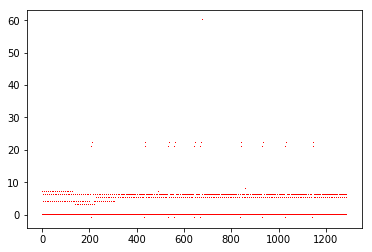

In [16]:
column_id = 33
plt.plot(temp_dummy[column_id].index.values, temp_dummy[column_id].values, ",r")

In [17]:
na_df[na_df.sum(axis=1) > 0]

,na_date,na_hour,na_code,na_value
26,3,0,0,3
28,30,0,0,30


In [18]:
### Droping NA
for ii in na_df[na_df.sum(axis=1) > 0].index.tolist():
    current_df = dataframe_container[ii]
    print("\n{:s}DATAFRAME {:d}{:s}".format(color.BOLD, ii + 1, color.END))
    print("\n\tCurrent NA : \t", end="")
    index_to_drop = current_df[current_df.isna().sum(axis=1) > 0].index.tolist()
    print(len(index_to_drop), end="\n")
    
    current_df.dropna(inplace=True)
    
    index_to_drop = current_df[current_df.isna().sum(axis=1) > 0].index.tolist()
    print("\n\tVerifyng Drop NA : \t", end="")
    print(len(index_to_drop), end="\n")
    


DATAFRAME 27

	Current NA : 	6

	Verifyng Drop NA : 	0

DATAFRAME 29

	Current NA : 	60

	Verifyng Drop NA : 	0


In [19]:
#Checking Non Valid/Wrong Data (not na)

non_val_container = []

for list_ii in patched_data:
    [ii, column_id] = list_ii
#     print(column_id)
    current_df = dataframe_container[ii]
    print("\n\n")
    print(current_df.iloc[: , :4].info())
    wrong_df = current_df[current_df[column_id] == -1]
    if wrong_df.empty:
        print(color.RED, "Empty", color.END)
    else:
        display(wrong_df)
        non_val_container += [[ii , wrong_df.index.values.tolist()]]




<class 'pandas.core.frame.DataFrame'>
Int64Index: 919 entries, 0 to 924
Data columns (total 4 columns):
Date     919 non-null object
Hour     919 non-null object
Code     919 non-null int64
Value    919 non-null object
dtypes: int64(1), object(3)
memory usage: 35.9+ KB
None
 Empty 



<class 'pandas.core.frame.DataFrame'>
Int64Index: 1228 entries, 0 to 1287
Data columns (total 4 columns):
Date     1228 non-null object
Hour     1228 non-null object
Code     1228 non-null int64
Value    1228 non-null object
dtypes: int64(1), object(3)
memory usage: 48.0+ KB
None
 Empty 



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Data columns (total 4 columns):
Date     760 non-null object
Hour     760 non-null object
Code     760 non-null int64
Value    760 non-null object
dtypes: int64(1), object(3)
memory usage: 23.8+ KB
None


,Date,Hour,Code,Value,33,34,35,48,57,58,...,63,64,65,66,67,68,69,70,71,72
220,11-06-1989,22:00,48,0Hi,0,0,0,-1,0,0,...,0,0,0,0,0,0,0,0,0,0
610,12-25-1989,22:00,48,0Hi,0,0,0,-1,0,0,...,0,0,0,0,0,0,0,0,0,0





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 4 columns):
Date     105 non-null object
Hour     105 non-null object
Code     105 non-null int64
Value    105 non-null object
dtypes: int64(1), object(3)
memory usage: 3.4+ KB
None


,Date,Hour,Code,Value,33,34,35,48,57,58,...,63,64,65,66,67,68,69,70,71,72
73,11-06-1989,11:00,57,0'',0,0,0,0,-1,0,...,0,0,0,0,0,0,0,0,0,0





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Data columns (total 4 columns):
Date     760 non-null object
Hour     760 non-null object
Code     760 non-null int64
Value    760 non-null object
dtypes: int64(1), object(3)
memory usage: 23.8+ KB
None


,Date,Hour,Code,Value,33,34,35,48,57,58,...,63,64,65,66,67,68,69,70,71,72
168,10-31-1989,12:00,60,0Hi,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
208,11-05-1989,12:00,60,0Hi,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
216,11-06-1989,12:00,60,0Hi,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Data columns (total 4 columns):
Date     760 non-null object
Hour     760 non-null object
Code     760 non-null int64
Value    760 non-null object
dtypes: int64(1), object(3)
memory usage: 23.8+ KB
None


,Date,Hour,Code,Value,33,34,35,48,57,58,...,63,64,65,66,67,68,69,70,71,72
202,11-04-1989,18:00,62,0Hi,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
234,11-08-1989,18:00,62,0Lo,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
for [df_id, rows_to_drop_id] in non_val_container:
    dataframe_container[df_id].drop(rows_to_drop_id, axis='index', inplace=True)

In [21]:
#RE - Checking Non Valid/Wrong Data (not na)

# non_val_container = []
everything_ok = True
for list_ii in patched_data:
    [ii, column_id] = list_ii
    wrong_df = current_df[current_df[column_id] == -1]
    if wrong_df.empty:
        print(color.RED, "Empty", color.END)
    else:
        everything_ok *= False
        
if not everything_ok:
    print(":c")
else:
    print("Success :)")

 Empty 
 Empty 
 Empty 
 Empty 
 Empty 
 Empty 
Success :)


In [22]:
for x in dataframe_container:
    x.index = np.arange(x.shape[0], dtype=int)

## Re Checking Data

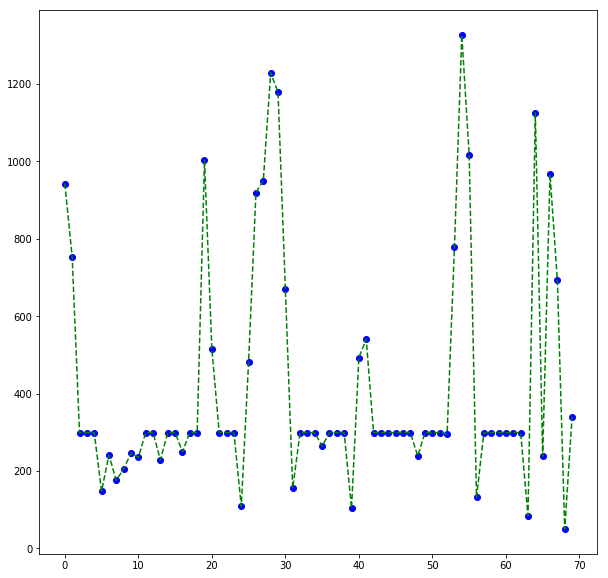

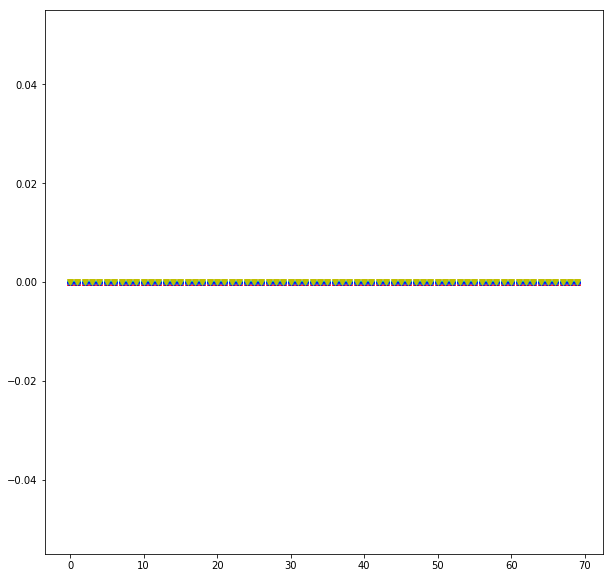

In [23]:
x_temp = np.arange(N_SAMPLES)
y_temp = []
y_na_date_temp = []
y_na_hour_temp = []
y_na_code_temp = []
y_na_value_temp = []
for dfc_element in dataframe_container:
    y_temp.append(dfc_element.shape[0])
    y_na_date_temp.append(dfc_element.Date.isnull().astype(int).sum())
    y_na_hour_temp.append(dfc_element.Hour.isnull().astype(int).sum())
    y_na_code_temp.append(dfc_element.Code.isnull().astype(int).sum())
    y_na_value_temp.append(dfc_element.Value.isnull().astype(int).sum())

na_df = pd.DataFrame(data=np.matrix([y_na_date_temp , y_na_hour_temp , y_na_code_temp , y_na_value_temp]).T, 
                     columns=["na_date", "na_hour", "na_code", "na_value"])

plt.figure(figsize=(10,10))

plt.plot(x_temp, y_temp, "ob")
plt.plot(x_temp, y_temp, "--g")

plt.show()

plt.figure(figsize=(10,10))

plt.plot(na_df.na_date, "^r")
plt.plot(na_df.na_hour, "ob")
plt.plot(na_df.na_code, "*c")
plt.plot(na_df.na_value, "vy")

plt.show()

In [24]:
patched_data = []
for ii in code_names.T:
    
    [code, label_str] = code_names.T[ii].tolist()
    print("\n{:s}STATE\t: {:d} {:s}{:s}".format(color.BOLD, code, label_str, color.END))

    ref_idx = 0
    for ref_dataframe in dataframe_container:
        temp_data = np.zeros(ref_dataframe.shape[0], dtype=int)
        index_list = ref_dataframe[ref_dataframe.Code == code].index.tolist()
        
        try:
            temp_data[index_list] = ref_dataframe.Value[index_list]
        except:
            print("\n\t{:s}data-{:2d}{:s}".format( color.BLUE, ref_idx + 1, color.END))
            
            ref_vals = ref_dataframe.Value[index_list]
            print("\t\t", ref_vals.describe(), end="")
            
            print("\n\n\t\t\t{:s}Patching...{:s}".format(color.DARKCYAN, color.END), end="\n")
            ref_vals = ref_vals.apply(alter_val_int).astype(int)
            temp_data[index_list] = ref_vals
            
            patched_data += [[ref_idx, code]]
        else:
            pass
        
        ref_dataframe[code] = temp_data
        ref_idx += 1



STATE	: 33 Regular insulin dose

STATE	: 34 NPH insulin dose

STATE	: 35 UltraLente insulin dose

STATE	: 48 Unspecified blood glucose measurement

STATE	: 57 Unspecified blood glucose measurement

STATE	: 58 Pre-breakfast blood glucose measurement

STATE	: 59 Post-breakfast blood glucose measurement

STATE	: 60 Pre-lunch blood glucose measurement

STATE	: 61 Post-lunch blood glucose measurement

STATE	: 62 Pre-supper blood glucose measurement

STATE	: 63 Post-supper blood glucose measurement

STATE	: 64 Pre-snack blood glucose measurement

STATE	: 65 Hypoglycemic symptoms

STATE	: 66 Typical meal ingestion

STATE	: 67 More-than-usual meal ingestion

STATE	: 68 Less-than-usual meal ingestion

STATE	: 69 Typical exercise activity

STATE	: 70 More-than-usual exercise activity

STATE	: 71 Less-than-usual exercise activity

STATE	: 72 Unspecified special event


### Re-Parsing Columns

In [25]:
ref_df = dataframe_container[0]

In [26]:
def date_spliter(date_str):
    return list(map(lambda x: int(x), date_str.split("-")))

def hour_spliter(hour_str):
    return list(map(lambda x: int(x), hour_str.split(":")))

In [27]:
wrong_formated_date_idx = []
for ii in range(len(dataframe_container)):
    ref_df = dataframe_container[ii]
    
    ref_df.Value = ref_df.Value.astype(dtype=int)
    ref_df.Code = ref_df.Code.astype(dtype=int)
    
    try:
        ref_df["Time"] = pd.to_datetime(ref_df.Date.map(str) + " " + ref_df.Hour)
    except ValueError:
        wrong_formated_date_idx += [ii]
        ref_df["Time"] = pd.to_datetime(ref_df.Date.map(str) + " " + ref_df.Hour, errors='coerce')
    else:
        pass

In [28]:
for kk in wrong_formated_date_idx:
    ref_df = dataframe_container[kk]
    
    print("\n\n{:s}Date and Hour {:d}{:s}".format(color.BOLD, kk, color.END))
    display(ref_df.Date.describe())
    display(ref_df.Date.unique())
    
    display(ref_df.Hour.describe())
    display(ref_df.Hour.unique())
    
    sub_df = ref_df[ref_df.Time.isna().astype(int) == 1].iloc[:, :4]
    display(sub_df)
    
    print("\n\n\t{:s}Patching...{:s}".format(color.DARKCYAN, color.END))
    ref_df.drop(sub_df.index.tolist(), axis='index', inplace=True)
    
    sub_df = ref_df[ref_df.Time.isna().astype(int) == 1].iloc[:, :4]
    if sub_df.empty:
        print("\t\t{:s}Success{:s}".format(color.BLUE, color.END))
    else:
        print("\t\t{:s}:c{:s}".format(color.BLUE, color.END))



Date and Hour 19


count           1002
unique           135
top       09-14-1991
freq               9
Name: Date, dtype: object

array(['05-12-1991', '05-13-1991', '05-14-1991', '05-15-1991',
       '05-16-1991', '05-17-1991', '05-18-1991', '05-19-1991',
       '05-20-1991', '05-21-1991', '05-22-1991', '05-23-1991',
       '05-24-1991', '05-25-1991', '05-26-1991', '05-27-1991',
       '05-28-1991', '05-29-1991', '05-30-1991', '05-31-1991',
       '06-01-1991', '06-02-1991', '06-03-1991', '06-04-1991',
       '06-05-1991', '06-06-1991', '06-07-1991', '06-08-1991',
       '06-09-1991', '06-10-1991', '06-11-1991', '06-12-1991',
       '06-13-1991', '06-14-1991', '06-15-1991', '06-16-1991',
       '06-17-1991', '06-18-1991', '06-19-1991', '06-20-1991',
       '06-21-1991', '06-22-1991', '06-23-1991', '06-24-1991',
       '06-25-1991', '06-26-1991', '06-27-1991', '06-28-1991',
       '06-29-1991', '06-31-1991', '07-01-1991', '07-02-1991',
       '07-03-1991', '07-04-1991', '07-05-1991', '07-06-1991',
       '07-07-1991', '07-08-1991', '07-09-1991', '07-10-1991',
       '07-11-1991', '07-12-1991', '07-13-1991', '07-14

count      1002
unique      176
top       12:00
freq         50
Name: Hour, dtype: object

array(['06:55', '11:20', '17:00', '04:55', '11:00', '05:30', '09:50',
       '17:10', '22:20', '05:25', '12:20', '18:00', '05:00', '18:55',
       '05:10', '12:50', '20:10', '10:05', '15:45', '20:45', '08:15',
       '12:35', '19:15', '06:05', '12:10', '18:40', '21:50', '04:35',
       '11:45', '17:30', '07:30', '12:15', '20:15', '07:00', '11:50',
       '17:55', '22:05', '06:00', '11:55', '18:25', '10:20', '12:45',
       '17:45', '23:45', '12:30', '09:00', '14:45', '18:05', '22:45',
       '06:45', '12:00', '18:10', '23:59', '06:40', '06:20', '06:50',
       '11:42', '09:35', '11:25', '18:50', '06:30', '22:30', '12:05',
       '18:15', '22:15', '06:25', '07:20', '11:40', '18:45', '07:05',
       '17:20', '22:40', '07:35', '07:55', '14:10', '16:45', '06:35',
       '16:05', '21:15', '09:40', '13:40', '23:00', '13:25', '19:00',
       '23:10', '13:50', '18:30', '22:50', '11:30', '17:15', '23:50',
       '04:25', '11:35', '19:55', '23:20', '08:00', '13:30', '19:50',
       '08:35', '11:

,Date,Hour,Code,Value
362,06-31-1991,07:50,58,149
363,06-31-1991,07:50,33,4
364,06-31-1991,07:50,34,24
365,06-31-1991,13:30,60,162
366,06-31-1991,13:30,33,5
367,06-31-1991,19:45,62,213
368,06-31-1991,19:45,33,11




	Patching...
		Success


Date and Hour 66


count            966
unique           120
top       04-08-1991
freq              12
Name: Date, dtype: object

array(['01-01-1991', '01-02-1991', '01-03-1991', '01-04-1991',
       '01-05-1991', '01-06-1991', '01-07-1991', '01-08-1991',
       '01-09-1991', '01-10-1991', '01-11-1991', '01-12-1991',
       '01-13-1991', '01-14-1991', '01-15-1991', '01-16-1991',
       '01-17-1991', '01-18-1991', '01-19-1991', '01-20-1991',
       '01-21-1991', '01-22-1991', '01-23-1991', '01-24-1991',
       '01-25-1991', '01-26-1991', '01-27-1991', '01-28-1991',
       '01-29-1991', '01-30-1991', '01-31-1991', '02-01-1991',
       '02-02-1991', '02-03-1991', '02-04-1991', '02-05-1991',
       '02-06-1991', '02-07-1991', '02-08-1991', '02-09-1991',
       '02-10-1991', '02-11-1991', '02-12-1991', '02-13-1991',
       '02-14-1991', '02-15-1991', '02-16-1991', '02-17-1991',
       '02-18-1991', '02-19-1991', '02-20-1991', '02-21-1991',
       '02-22-1991', '02-23-1991', '02-24-1991', '02-25-1991',
       '02-26-1991', '02-27-1991', '02-28-1991', '03-01-1991',
       '03-02-1991', '03-03-1991', '03-04-1991', '03-05

count      966
unique     139
top       6:35
freq        93
Name: Hour, dtype: object

array(['9:10', '13:40', '17:50', '21:45', '6:40', '12:00', '18:00',
       '22:40', '6:30', '19:50', '23:30', '6:25', '19:05', '10:45',
       '18:35', '23:59', '8:30', '13:20', '18:20', '22:30', '6:35',
       '12:05', '18:15', '4:50', '12:10', '23:15', '23:00', '2:00',
       '18:45', '18:25', '22:05', '9:35', '17:55', '23:40', '8:05',
       '11:50', '2:10', '23:05', '18:10', '12:15', '22:50', '19:30',
       '22:45', '9:40', '17:45', '23:35', '1:30', '8:40', '12:20',
       '22:55', '11:55', '18:40', '22:00', '19:00', '12:25', '18:50',
       '10:15', '14:00', '18:30', '23:45', '13:45', '22:35', '3:00',
       '6:20', '10:10', '14:20', '8:15', '18:05', '21:40', '12:01',
       '11:30', '2:45', '11:35', '21:10', '12:45', '23:50', '11:15',
       '23:10', '6:45', '11:45', '6:50', '7:20', '17:25', '9:15', '17:30',
       '10:30', '8:45', '21:00', '10:00', '6:55', '9:00', '13:30',
       '12:18', '22:25', '08:00', '16:45', '23:20', '9:45', '17:51',
       '12:30', '11:00', '17:00', '12

,Date,Hour,Code,Value
791,04-09-1991,56:35,58,237
792,04-09-1991,56:35,33,16
793,04-09-1991,56:35,34,40
892,04-21-1991,188:00,62,128
893,04-21-1991,188:00,33,14




	Patching...
		Success


In [29]:
for x in dataframe_container:
    x.index = np.arange(x.shape[0], dtype=int)

### Formating and Saving

In [30]:
postproc_sizes_container = []
output_dataframe_container = []

for ref_df in dataframe_container:
    output_dataframe_container.append(ref_df[["Time", "Code", "Value"]].copy())
    postproc_sizes_container.append(output_dataframe_container[-1].shape[0])

In [31]:
dt_procss_df = pd.DataFrame(columns=["Pre", "Post"])

dt_procss_df.Pre = preproc_size_container
dt_procss_df.Post = postproc_sizes_container

dt_procss_df.index = np.arange(N_SAMPLES, dtype=int).tolist()

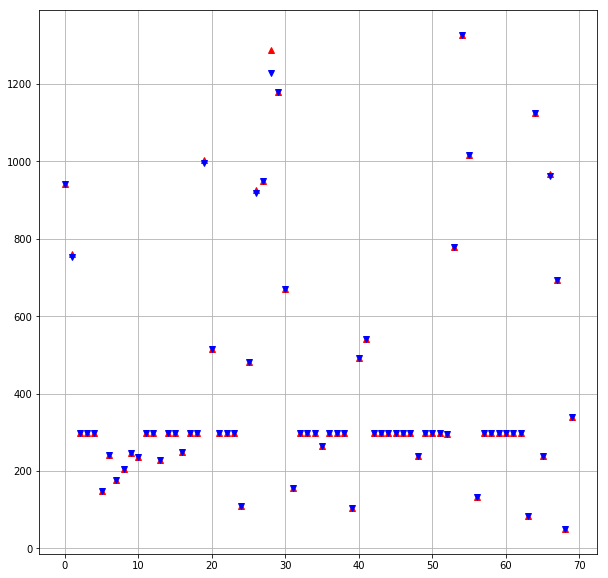

In [32]:
plt.figure(figsize=(10,10))
plt.grid()

plt.plot(dt_procss_df.Pre, "^r")
plt.plot(dt_procss_df.Post, "vb")

plt.show()    

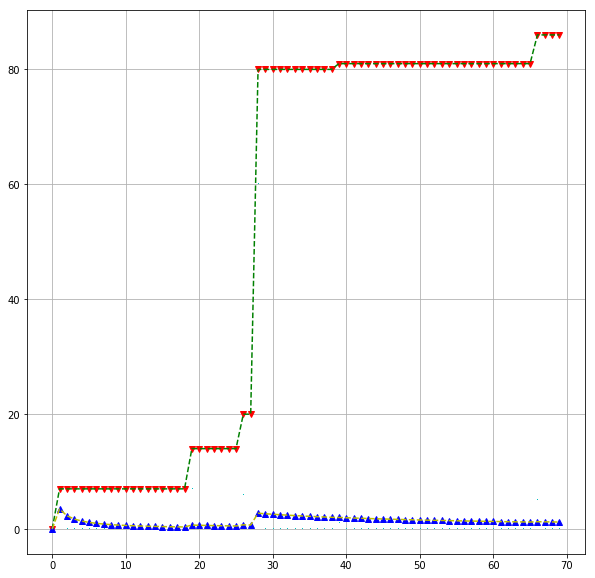

In [33]:
plt.figure(figsize=(10,10))
plt.grid()

diff_dt_procss = dt_procss_df.Pre - dt_procss_df.Post

plt.plot(diff_dt_procss, ",c")
plt.plot(diff_dt_procss.cumsum(), "vr")
plt.plot(diff_dt_procss.cumsum(), "--g")

plt.plot(diff_dt_procss.cumsum()/ (diff_dt_procss.index + 1), "^b")
plt.plot(diff_dt_procss.cumsum()/(diff_dt_procss.index + 1), "--y")

plt.show()    

### Saving

In [34]:
index_id = 1
for ww in output_dataframe_container:
    ww.to_csv("./diabetes_csv_{:2d}".format(index_id))
    index_id += 1